The goal of this exploration is to try to identify interaction terms that might be significant predictors.

For example, we already know that reference ranges for various BIA measures are differentiated by sex and age, so it seems reasonable that we might find interactions.

This work is slightly informed by my reading an online textbook about feature engineering: https://bookdown.org/max/FES/

This notebook will use a couple of different techniques to explore potential interactions. Some will be pretty naive, and others somewhat uninformed (i.e., informed by internet forums)

Planned approaches:
1. Use a random forest regressor (as suggested in this stackexchange forum: https://stats.stackexchange.com/questions/4901/what-are-best-practices-in-identifying-interaction-effects)
2. Including interaction terms in a model and then using Lasso regression (as suggested in the same forum, and also in the textbook listed above). See https://www.geeksforgeeks.org/feature-selection-using-selectfrommodel-and-lassocv-in-scikit-learn/ for instructions
3. Starting with a full model and testing interaction terms one-by-one. This has the issue of generating false positives. Potential solutions are a Bonferroni correction (likely too conservative) and a False Discovery Rate correction (which I still need to learn more about). Or maybe split the data in half, use half for testing and then run a more limited number of planned contrasts on the saved data.
4. Comparing each pairwise model with a model that also includes the interaction term. This has the same issues/limiations as the previous approach

All of these approaches need to be conducted using cross-validation in some way to try to reduce Type 1 errors.

I'm also thinking that I should start with some EDA to identify variables that are highly correlated and, probably, only use one of each set of highly-correlated variables in cases where I'm using a full model.

In [13]:
import pandas as pd
import numpy as np

Start by loading the data and merging it with the accelerometer data generated by Accelerometer_enmo_anglez_daily_averages.

In [14]:
# Load the data set train_imp.csv
train = pd.read_csv('train_cleaned.csv')

# Some of the code below is made redundant by changes to the Data_Cleaning notebook

# Load the accelerometer data set Accelerometer_enmo_anglez_daily_averages.csv
accel = pd.read_csv('Accelerometer_enmo_anglez_daily_averages.csv')

# Merge train  on the 'id' column and accel on the 'ID' column
#train_merged = train.merge(accel, left_on='id', right_on='ID')

# Create a data frame from accel that only includes ID values for which there is no match in the id column of train
accel_missing = accel[~accel['ID'].isin(train['id'])]

# It seems unlikly that we're going to want the ENMO_Avg_All_Days_MVPA192 or ENMO_Avg_All_Days_MVPA110 or Positive_Anglez_All_Days variables, so remove them
#train_merged = train_merged.drop(columns=['ENMO_Avg_All_Days_MVPA192', 'ENMO_Avg_All_Days_MVPA110', 'Positive_Anglez_All_Days'])

In [4]:
accel_missing.head(10)

,ID,ENMO_Avg_Active_Days_MVPA192,ENMO_Avg_Active_Days_MVPA110,ENMO_Avg_All_Days_MVPA192,ENMO_Avg_All_Days_MVPA110,Positive_Anglez_Active_Days,Positive_Anglez_All_Days
4,19455336,14.000000,36.250000,8.777778,18.166667,151.500000,75.733333
5,ca33a5e7,0.000000,0.000000,3.000000,5.666667,73.333333,32.230769
8,6b6467f4,0.000000,0.000000,5.000000,13.000000,0.000000,10.000000
22,b447e66d,14.818182,38.000000,14.869565,37.739130,136.772727,126.375000
24,adbd6839,18.400000,42.800000,17.761905,41.523810,41.200000,37.954545
38,035c96dd,4.000000,13.250000,4.000000,9.166667,63.000000,50.000000
40,ab16a20d,13.800000,37.000000,11.545455,29.545455,37.400000,28.583333
43,070386b2,7.500000,20.714286,7.307692,20.600000,68.812500,64.000000
45,3f1f23e7,19.428571,48.133333,17.210526,40.000000,88.133333,75.050000
46,e46417a7,12.842105,36.263158,12.280000,26.322581,60.000000,35.048780


There are lots of NaN values. We'll be imputing some/all of these later, but it's problematic to impute prior to doing our feature engineering. So let's explore the NaN distribution for the variables

In [15]:
# Compute the number of rows in train
print('There are',accel.shape[0],'rows in accel')
print('There are',train.shape[0],'rows in train')

# Compute the number of NaN values for each variable in train. Make a dataframe of the variables and their NaN counts
nan_counts = pd.DataFrame(train.isnull().sum(), columns=['nan_count'])

# Identify the five variables with the largest values in nan_count
nan_counts = nan_counts.sort_values(by='nan_count', ascending=False)
nan_counts.head(20)

There are 996 rows in accel
There are 796 rows in train


,nan_count
Physical-Waist_Circumference,757
Fitness_Endurance-Time_Sec,559
Fitness_Endurance-Time_Mins,559
Fitness_Endurance-Max_Stage,559
FGC-FGC_GSD_Zone,545
FGC-FGC_GSND_Zone,545
FGC-FGC_GSND,542
FGC-FGC_GSD,542
Fitness_Endurance-Season,373
PAQ_Total,259


We can (and should) drop some of these predictors before eliminating missing values?

We'll drop predictors that have over 300 missing rows.

Assuming the FitnessGram_Zone_Total can replace the individual FitnessGram Zone predictors, we can drop those individual predictors

In [16]:
# Remove variables with lots of NaN values: 
# 'Physical-Waist_Circumference'
# 'Fitness_Endurance-Time_Sec'
# 'Fitness_Endurance-Time_Mins'
# 'Fitness_Endurance-Max_Stage'
# 'FGC-FGC_GSD_Zone'
# 'FGC-FGC_GSND_Zone'
# 'FGC-FGC_GSND'
# 'FGC-FGC_GSD'
# 'Fitness_Endurance-Season'
train = train.drop(columns=['Physical-Waist_Circumference', 'Fitness_Endurance-Time_Sec', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Max_Stage', 'FGC-FGC_GSD_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'Fitness_Endurance-Season'])

# Remove the individual FitnessGram Zone predictors
# FGC-FGC_SRL_Zone
# FGC-FGC_SRR_Zone
# FGC-FGC_PU_Zone
# FGC-FGC_CU_Zone
# FGC-FGC_TL_Zone
train = train.drop(columns=['FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_CU_Zone', 'FGC-FGC_TL_Zone'])


# Drop all rows with NaN values
train = train.dropna()

In [38]:
# List all variables in train
train.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Diastolic_BP',
       'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-Season',
       'FGC-FGC_CU', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_TL', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_DEE',
       'BIA-BIA_Frame_num', 'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02',
       'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06',
       'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10',
       'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14',
       'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18',
       'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total', 'SDS-Season',
       'SDS-SDS_Total_Raw', 'PreInt_EduHx-Season',
       'PreInt_EduHx-computerinternet

Before listing likely interaction terms, we should probably check to see if/how many of these variables are closely correlated. If they are, then we should probably drop one of each pair?

This is certainly true if we want to use Lasso, which doesn't work with correlated variables.

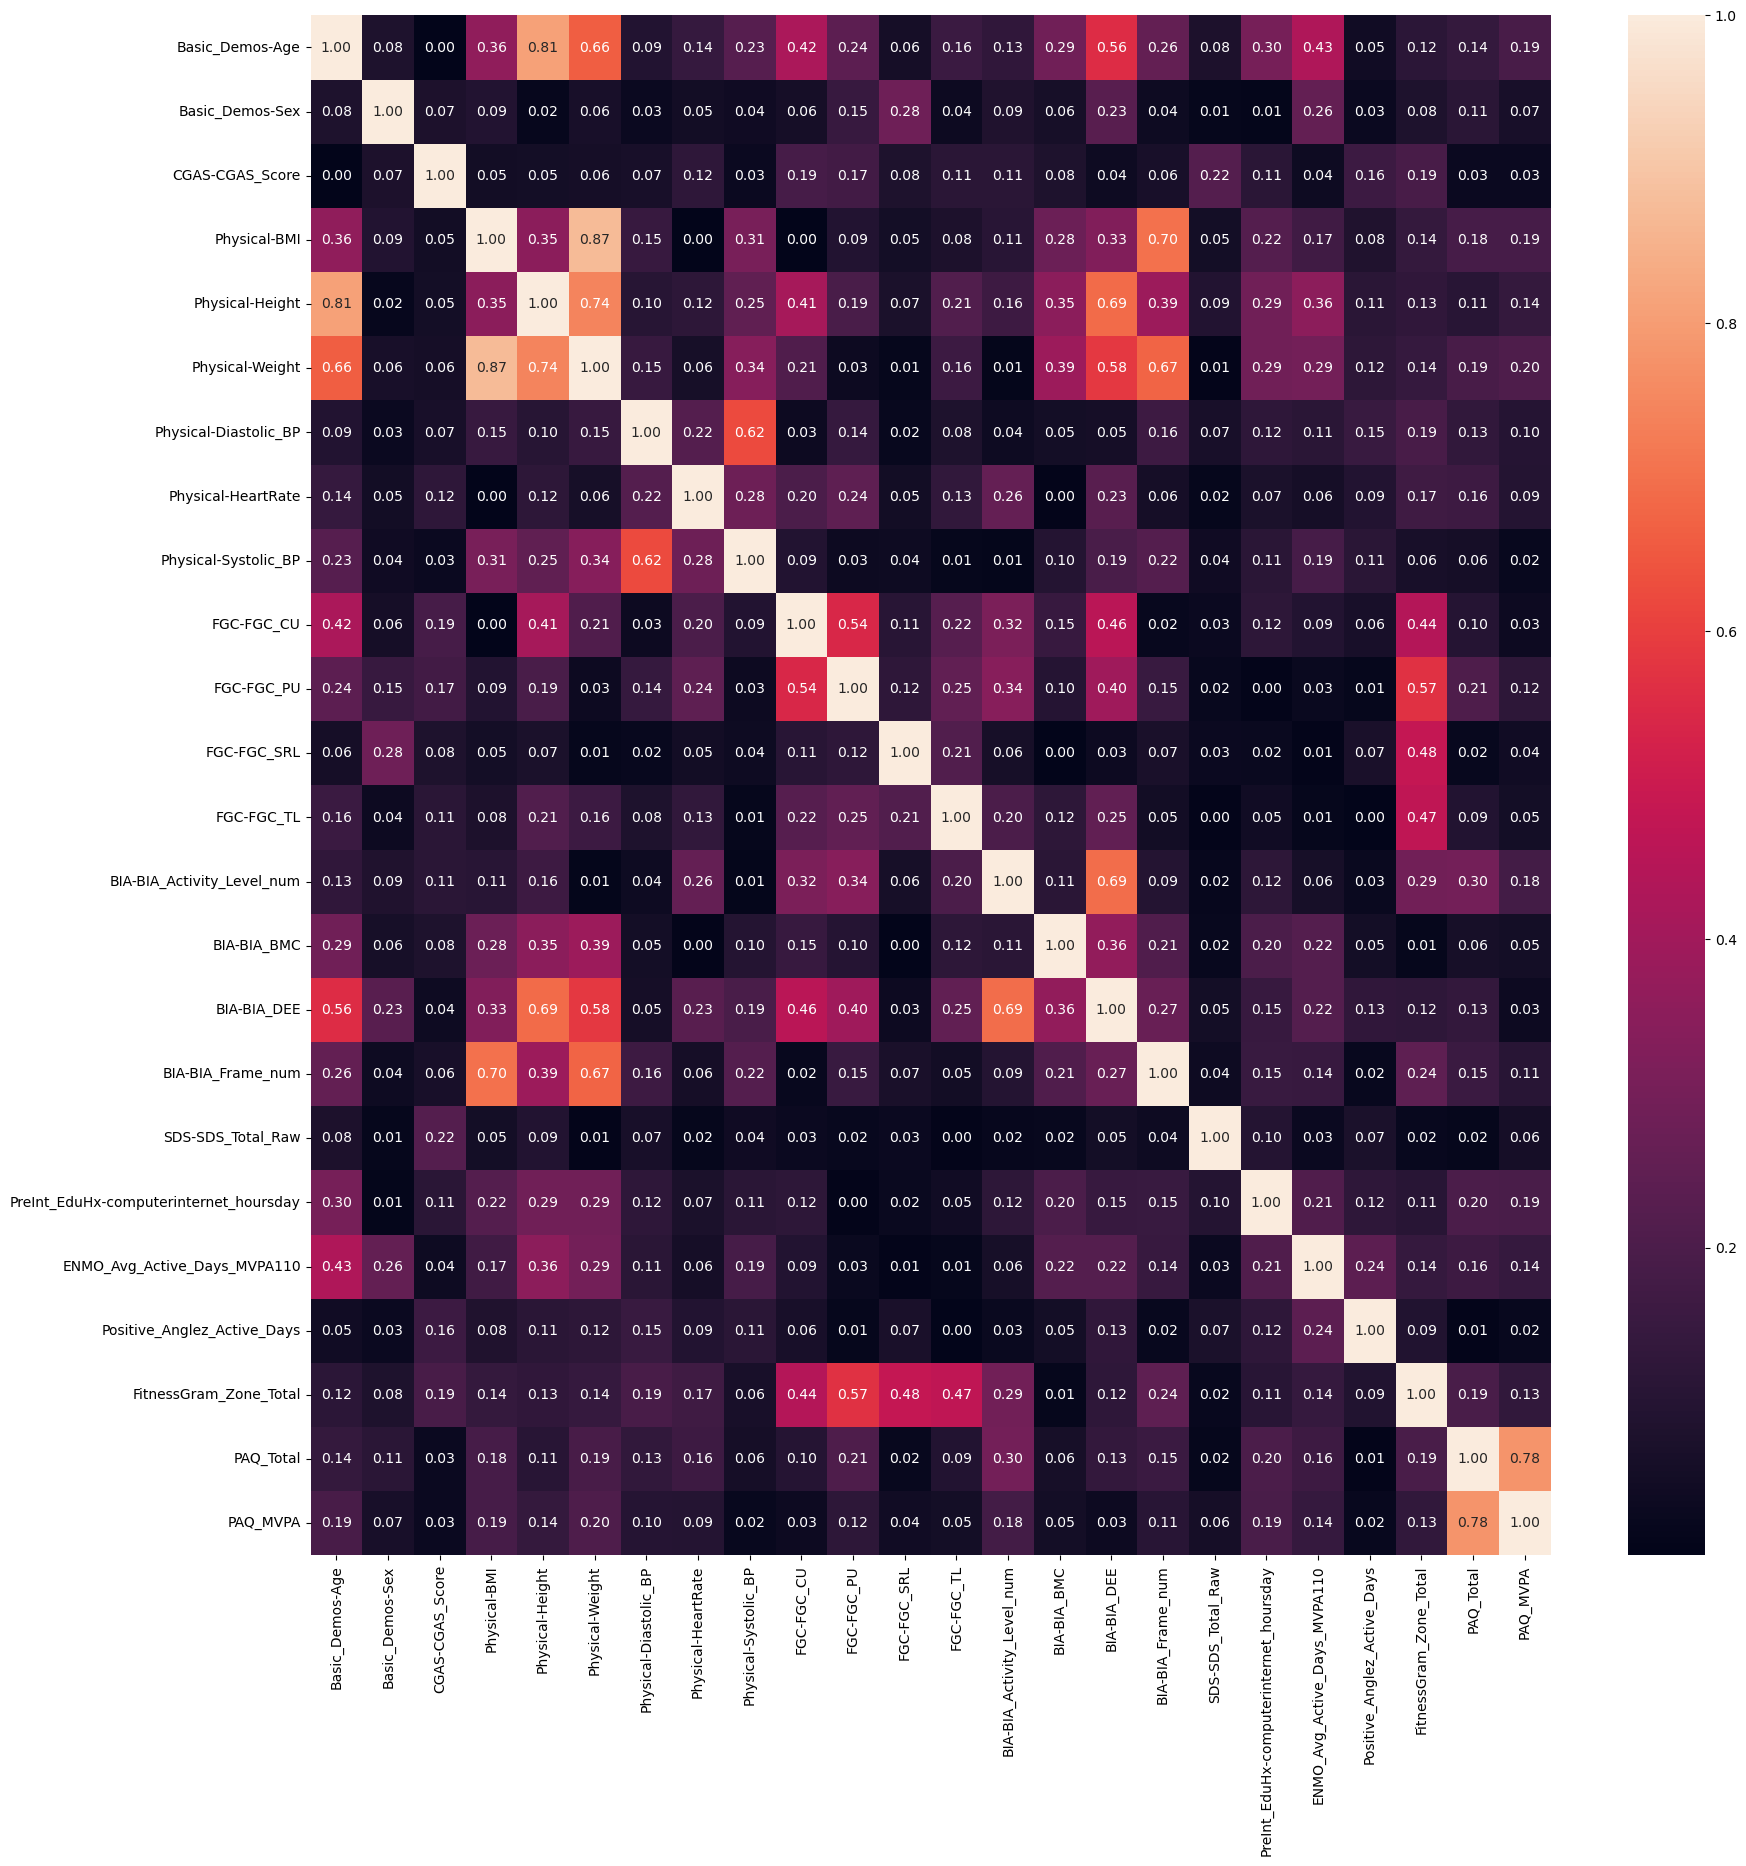

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make a list of all integer and float variables in train
num_vars = train.select_dtypes(include=['int64', 'float64']).columns

# Exclude all variables that start with  'PCIAT'from num_vars
num_vars = [var for var in num_vars if not var.startswith('PCIAT')]

# Remove sii from num_vars
num_vars.remove('sii')

# Compute the pairwise correlation for each pair of variables in num_vars
correlation_matrix = train[num_vars].corr()

# Compute absolute values of correlation_matrix
correlation_matrix = np.abs(correlation_matrix)

# Make a 20x20 heatmap of correlation_matrix
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()


Some sources (https://pmc.ncbi.nlm.nih.gov/articles/PMC6107969/) suggest that, in medicine, correlations are regarded as "strong" when they are at least 0.8. We'll use that as a threshold

In [34]:
# List all pairs of variables in num_vars that have correlation at least 0.8 and less than 1
correlated_vars = []
for i in range(len(num_vars)):
    for j in range(i+1, len(num_vars)):
        if correlation_matrix.iloc[i,j] >= 0.8 and correlation_matrix.iloc[i,j] < 1:
            correlated_vars.append((num_vars[i], num_vars[j]))

# Add the correlation values to correlated_vars
correlated_vars = [(var1, var2, correlation_matrix.loc[var1, var2]) for var1, var2 in correlated_vars]

# Save correlated_vars to a csv
correlated_vars_df = pd.DataFrame(correlated_vars, columns=['var1', 'var2', 'correlation'])
correlated_vars_df.to_csv('correlated_vars.csv', index=False)

The following variables are either closely (≥0.8) correlated with two others or very strongly (≥0.9) correlated with at least one other and can be removed from our search:
* BIA-BIA_BMI (predicted by Physical-BMI and Physical-Weight)
* BIA-BIA_BMR (predicted by Physical-Height and Physical-Weight)
* BIA-BIA_ECW (predicted by Physical-Height and Physical-Weight)
* BIA-BIA_FFM (predicted by Physical-Height and Physical-Weight)
* BIA-BIA_FFMI (predicted by Physical-BMI and Physical-Weight)
* BIA-BIA_FMI (predicted by Physical-BMI and Physical-Weight)
* BIA-BIA_Fat (predicted by Physical-BMI and Physical-Weight)
* BIA-BIA_ICW (predicted by Physical-Height and Physical-Weight... both at 0.79, but removing anyway)
* BIA-BIA_LDM (predicted by Physical-Height and Physical-Weight)
* BIA-BIA_LST (predicted by Physical-Height and Physical-Weight)
* BIA-BIA_SMM (predicted by Physical-Height and Physical-Weight... at 0.77 and 0.8, but removing anyway)
* BIA-BIA_TBW (predicted by Physical-Height and Physical-Weight)
(so the only BIA variables we're keeping are BIA-BIA_BMC, BIA-BIA_DEE, and BIA-BIA_Frame_num)
* FGC-FGC_SRR (predicted by FGC-FGC_SRL)
* SDS-SDS_Total_T (predicted by SDS-SDS_Total_Raw)
* ENMO_Avg_Active_Days_MVPA192 (predicted by the 110 version)
* (might consider removing PAQ_MVPA, which has correlation 0.78 with PAQ_Total)

In [35]:
# Remove the variables
train = train.drop(columns=['BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'FGC-FGC_SRR', 'SDS-SDS_Total_T', 'ENMO_Avg_Active_Days_MVPA192'])

Next, we should examine the categorical variables

In [43]:
# List all of the non-integer and non-float variables in train
non_num_vars = train.select_dtypes(exclude=['int64', 'float64']).columns
non_num_vars

Index(['ID'], dtype='object')

Some of these variables don't need to be considered (ID and sii).

Others might be part of a more complex interaction. For example, suppose the CGAS score doesn't interact with FitnessGram, but it would if we included the FGC-Season and/or CGAS-Season variables.

Maybe the solution is to create new season-overlap variables for each pair of season variables that are 1 if the seasons match and 0 if they don't? Then include that in each relevant potential interaction?

Let's add all of these interaction variables and then do a bit of EDA

In [ ]:
# Remove the ID and sii variables from train
train = train.drop(columns=['id', 'sii','ID'])

KeyError: "['id', 'sii'] not found in axis"

In [42]:
# Create a list of variables that end with the text 'Season'
season_vars = [var for var in train.columns if var.endswith('Season')]

# For each pair of variables in season_vars, create a new variable that is 1 if the values of the variables are the same and 0 otherwise
for i in range(len(season_vars)):
    for j in range(i+1, len(season_vars)):
        new_var_name = season_vars[i] + '_' + season_vars[j] + '_Match'
        train[new_var_name] = (train[season_vars[i]] == train[season_vars[j]]).astype(int)

# Remove the variables in season_vars from train
train = train.drop(columns=season_vars)

In [55]:
# Remove all variables from tain that start with PCIAT-PCIAT_0
train = train.drop(columns=[var for var in train.columns if var.startswith('PCIAT-PCIAT_0')])
train = train.drop(columns=[var for var in train.columns if var.startswith('PCIAT-PCIAT_1')])
train = train.drop(columns=[var for var in train.columns if var.startswith('PCIAT-PCIAT_2')])

**RF Regressor Interaction Terms**
(from Brave AI and also https://towardsdatascience.com/random-forest-regression-5f605132d19d... and I need to dig back in to https://www.geeksforgeeks.org/random-forest-regression-in-python/)

Random Forest Regressor is a powerful ensemble learning algorithm that can capture complex relationships between variables, including interaction terms. However, it does not explicitly model interactions like linear regression does with polynomial terms. Instead, Random Forest Regressor identifies interactions through feature selection and variable importance.

Approach

Prepare your data: Ensure your dataset is clean, and features are scaled (e.g., using StandardScaler from scikit-learn).

Split your data: Divide your dataset into training (e.g., 80%) and testing sets (e.g., 20%) using train_test_split from scikit-learn.

Train a Random Forest Regressor: Use RandomForestRegressor from scikit-learn with default hyperparameters (e.g., n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1).

Compute feature importance: Use the feature_importances_ attribute of the trained Random Forest Regressor to identify the most important features.

Inspect feature interactions: Analyze the feature importance scores and look for features that have high importance and are correlated with each other. This can indicate potential interaction terms.

The code example below identifies the most important features using Random Forest Regressor’s feature importance scores. It then computes the correlation matrix between these important features and looks for pairs with a correlation coefficient greater than 0.5. This can indicate potential interaction terms between the features.

Limitations
While Random Forest Regressor can identify interactions, it may not capture all possible interactions, especially those with non-linear relationships. Additionally, the feature importance scores may not always accurately reflect the strength of interactions.

In [ ]:
# Here is code to do random forest resgressor (thanks, Brave AI!)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train.drop('PCIAT-PCIAT_Total', axis=1), train['PCIAT-PCIAT_Total'], test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# We can use a grid search to tune the random forest...? 
# Define Grid
#grid = { 
#    'n_estimators': [200,300,400,500],
#    'max_features': ['sqrt','log2'],
#    'max_depth' : [3,4,5,6,7],
#    'random_state' : [42]
#}
## Grid Search function
#CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid1, cv= 5)
#CV_frf.fit(x_train, y_train)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=300, criterion = 'squared_error', max_depth = None, max_features='sqrt', bootstrap=True)
rf.fit(X_train_scaled, y_train)

# Compute feature importance
importances = rf.feature_importances_

# Inspect feature interactions
correlation_matrix = pd.DataFrame(X_train_scaled).corr()
important_features = [feature for feature, importance in zip(X_train.columns, importances) if importance > 0.1]
for feature1, feature2 in itertools.combinations(important_features, 2):
    if abs(correlation_matrix[feature1][feature2]) > 0.5:
        print(f"Potential interaction: {feature1} and {feature2}")

Next we'll try using LASSO on a full model including interaction terms

Some ideas here: https://www.geeksforgeeks.org/feature-selection-using-selectfrommodel-and-lassocv-in-scikit-learn/

In [63]:
# Import libraries
from sklearn.linear_model import LassoCV 
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.ensemble import RandomForestClassifier 
import matplotlib.pyplot as plt 
import seaborn as sns 
  
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(train.drop('PCIAT-PCIAT_Total', axis=1), train['PCIAT-PCIAT_Total'], test_size=0.2, random_state=42)

# Fit LassoCV model 
lasso_cv = LassoCV(cv=5) 
lasso_cv.fit(X_train, y_train) 

# Feature selection 
sfm = SelectFromModel(lasso_cv, prefit=True) 
X_train_selected = sfm.transform(X_train) 
X_test_selected = sfm.transform(X_test) 

# Train a Random Forest Classifier using the selected features 
model = RandomForestClassifier(n_estimators=100, random_state=42) 
model.fit(X_train_selected, y_train) 


# Evaluate the model 
y_pred = model.predict(X_test_selected) 
print(classification_report(y_test, y_pred)) 

# Analyze selected features and their importance 
selected_feature_indices = np.where(sfm.get_support())[0] 
selected_features = train.columns[selected_feature_indices] 
coefficients = lasso_cv.coef_ 
print("Selected Features:", selected_features) 
print("Feature Coefficients:", coefficients) 

# Extract the selected features from the original dataset 
X_selected_features = X_train[:, selected_feature_indices] 

# Create a DataFrame for better visualization 
selected_features_df = pd.DataFrame(X_selected_features, columns=selected_features) 

# Add the target variable for coloring 
selected_features_df['target'] = y_train 

# Plot the two most important features 
sns.scatterplot(x='mean area', y='worst area', hue='target', data=selected_features_df, palette='viridis') 
plt.xlabel('Mean Area') 
plt.ylabel('Worst Area') 
plt.title('Scatter Plot of Two Most Important Features') 
plt.show() 


/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/erdos_fall_2024/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

         0.0       0.22      0.50      0.31         4
         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         2
         3.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00         1
         8.0       0.00      0.00      0.00         1
         9.0       0.00      0.00      0.00         0
        10.0       0.00      0.00      0.00         2
        11.0       0.00      0.00      0.00         3
        12.0       0.00      0.00      0.00         1
        17.0       0.00      0.00      0.00         1
        18.0       0.00      0.00      0.00         1
        20.0       0.00      0.00      0.00         2
        21.0       0.00      0.00      0.00         4
        23.0       0.00      0.00      0.00         1
        25.0       0.00      0.00      0.00         0
        26.0       0.00      0.00      0.00         2
        27.0       0.00    

InvalidIndexError: (slice(None, None, None), array([ 0,  2,  4,  5,  7,  8,  9, 10, 11, 15, 17, 18, 19, 20]))

Below is my old code for trying to do Ridge CV. Keeping it here in case it's helpful

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Set up the kfold split
num_splits = 5
kfold = KFold(num_splits, shuffle=True)

# Define a range of alpha values
alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
numalphas = len(alphas)

# Create an empty array with num_splits rows and numalphas columns
rmses = np.zeros((num_splits, numalphas))

# Iterate over the three data sets
listofdatasets = [train_physical, train_fitness, train_bia]

# A data frame to store the optimal alpha values
bestalphas = pd.DataFrame(index=range(0,len(listofdatasets)))
bestalphas['dfname'] = ''
bestalphas['best_alpha_manual'] = np.nan

k=0
for df in listofdatasets:
    i = 0
    for train_index, test_index in kfold.split(df):
        tt_X = df.iloc[train_index].drop(columns=['PCIAT-PCIAT_Total'])
        tt_y = df.iloc[train_index]['PCIAT-PCIAT_Total']
        ho_X = df.iloc[test_index].drop(columns=['PCIAT-PCIAT_Total'])
        ho_y = df.iloc[test_index]['PCIAT-PCIAT_Total']

        # Iterate over alpha values with counter j
        j = 0
        for alpha in alphas:
            ridge_pipe = Pipeline([('scale', StandardScaler()),('ridge', Ridge(alpha=alpha, max_iter=5000000) )])
            ridge_pipe.fit(tt_X, tt_y)
            y_pred = ridge_pipe.predict(ho_X)
            rmses[i, j] = root_mean_squared_error(ho_y, y_pred)
            
            j=j+1

        i=i+1

    # Compute the mean of each column of rmses
    mean_rmses_within_alphas = np.mean(rmses, axis=0)

    # Compute the mean and standard deviation of each row of rmses
    mean_rmses = np.mean(mean_rmses_within_alphas, axis=0)
    std_rmses = np.std(mean_rmses_within_alphas, axis=0)

    # Identify the column of min_rmse that contains the minimum value
    best_alpha_index = np.argmin(mean_rmses_within_alphas)

    bestalphas.loc[k,'dfname'] = df.name
    bestalphas.loc[k,'best_alpha_manual'] = alphas[best_alpha_index]

    print('The alpha value with the lowest RMSE for the', df.name ,'variables is', alphas[best_alpha_index],'. The mean RMSE was', mean_rmses, ' and the standard deviation was', std_rmses )
    i=0
    j=0
    k=k+1

The alpha value with the lowest RMSE for the train_physical variables is 1 . The mean RMSE was 18.671645670338425  and the standard deviation was 0.06737420892180142
The alpha value with the lowest RMSE for the train_fitness variables is 10 . The mean RMSE was 19.05639718656873  and the standard deviation was 0.1264963289808006
The alpha value with the lowest RMSE for the train_bia variables is 10 . The mean RMSE was 18.689746957787783  and the standard deviation was 0.04291388407312609


In [41]:
bestalphas

,dfname,best_alpha_manual
0,train_physical,0.1
1,train_fitness,10.0
2,train_bia,10.0


Just for kicks, I'm going to try this out with the RidgeCV class

This will make it easier for me to try a wider range of alpha values

In [ ]:
from sklearn.linear_model import LassoCV

# A data frame to store the optimal alpha values
bestalphas = pd.DataFrame(index=range(0,len(listofdatasets)))
bestalphas['dfname'] = ''
bestalphas['best_alpha_manual'] = np.nan
bestalphas['best_alpha_automatic'] = np.nan

alphas = 10**np.linspace(10,-2,100)*0.5
#alphas = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]

for df in listofdatasets:
    X_train = df.drop(columns=['PCIAT-PCIAT_Total'])
    y_train = df['PCIAT-PCIAT_Total']
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_std = scaler.transform(X_train)
    lassocv = LassoCV(alphas = alphas, scoring = 'neg_root_mean_squared_error')
    lassocv.fit(X_std, y_train)
    bestalphas.loc[bestalphas['dfname']==df.name,'best_alpha_automatic']=lassocv.alpha_.astype(np.float64)

In [62]:
bestalphas

,dfname,best_alpha_manual,best_alpha_automatic
0,train_physical,1.0,2.320794
1,train_fitness,10.0,16.372746
2,train_bia,10.0,16.372746


Now that the hyperparameter is tuned, we'll compare the performance of the ridge regression and a PCA.

Note that in previous explorations we've identified n=3 as the "ideal" number of PCA components for each set of predictor variables

In [11]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression


for df in listofdatasets:
    # Identify the best alpha value we computed earlier
    best_alpha = bestalphas.loc[bestalphas['dfname'] == df.name, 'best_alpha'].values[0]
    
    # Instantiate some models. From previous exploration, we've been using 3 components for the PCA
    ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge(alpha = best_alpha, max_iter=5000000))])
    pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(n_components=3)), ('reg', LinearRegression())])

    # The training data
    X_train = df.iloc[train_index].drop(columns=['PCIAT-PCIAT_Total'])
    y_train =  df.iloc[train_index]['PCIAT-PCIAT_Total']

    # Fit the models to the training data
    ridge_pipe.fit(X_train, y_train)
    pca_pipe.fit(X_train, y_train)

    # Find the model predictions on the training set
    ridge_train_preds = ridge_pipe.predict(X_train)
    pca_train_preds = pca_pipe.predict(X_train)

    # Find the mse on the training set
    ridge_train_rmse = root_mean_squared_error(y_train, ridge_train_preds)
    pca_train_rmse = root_mean_squared_error(y_train, pca_train_preds)

    # Results
    print(df.name, f"Ridge Training MSE: {ridge_train_rmse}")
    print(df.name, f"PCA Training MSE: {pca_train_rmse}")

train_physical Ridge Training MSE: 18.533899980839752
train_physical PCA Training MSE: 19.235425201158005
train_fitness Ridge Training MSE: 18.695066004261484
train_fitness PCA Training MSE: 19.37497603121806
train_bia Ridge Training MSE: 18.770987125663712
train_bia PCA Training MSE: 19.057632568137585
